In [1]:
# !pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [1]:
import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator
setup_logger()

<Logger detectron2 (DEBUG)>

In [2]:
dataDir=Path('./input/')
cfg = get_cfg()
print(cfg)
cfg.INPUT.MASK_FORMAT='bitmask'
DatasetCatalog.clear()
register_coco_instances('sart_train',{}, './input/annotations_train.json', dataDir)
register_coco_instances('sart_val',{},'./input/annotations_val.json', dataDir)
metadata = MetadataCatalog.get('sart_train')
train_ds = DatasetCatalog.get('sart_train')

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ()
  TRAIN: ()
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (800,)
  MIN_SIZE_TRAIN_SAMPLING: choice
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32, 64, 128, 256, 512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: []
    NORM: 
    OUT_CHANNELS: 256
  KEYPOINT_ON: False
  LOAD_PROPOSALS: False
  MASK_ON: False
  META_

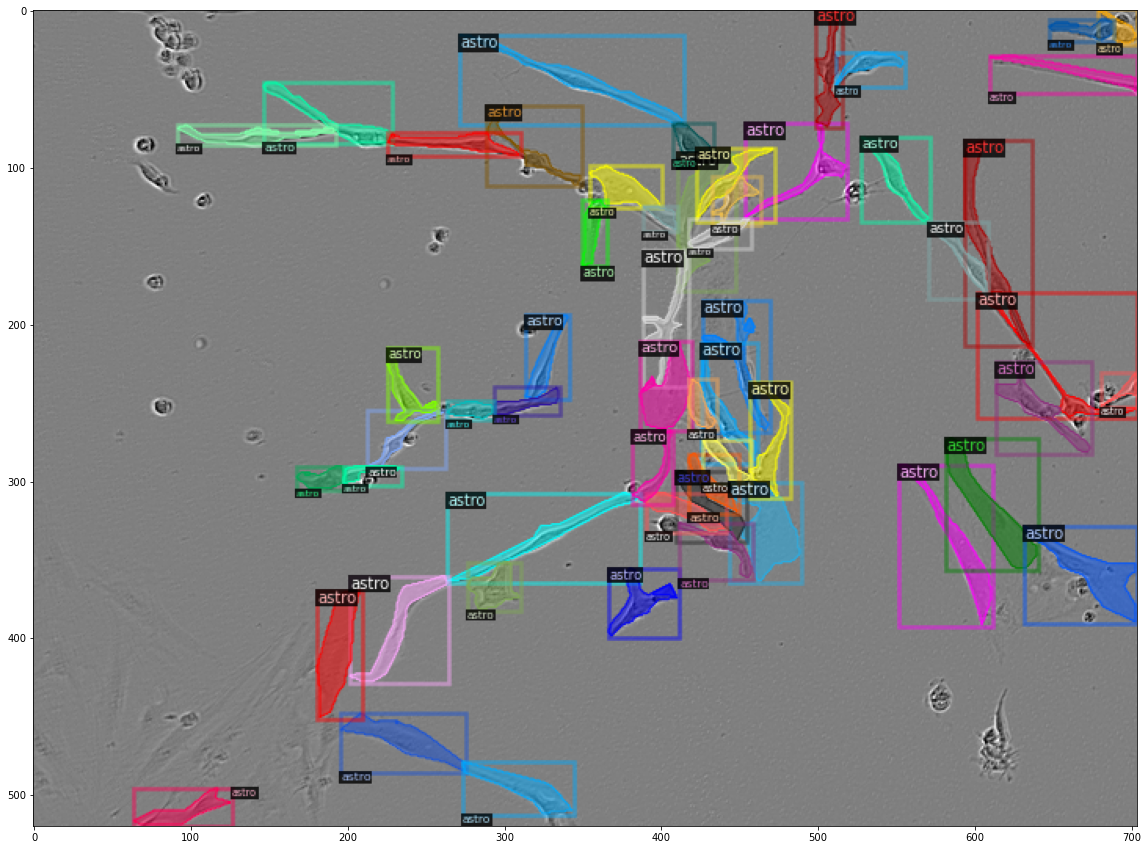

In [3]:
d = train_ds[42]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])

In [4]:
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)


cfg.merge_from_file("/home/yiw/conda/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-InstanceSegmentation/mask_rcnn_ResNeSt_50_FPN_syncBN_1x.yaml")
cfg.DATASETS.TRAIN = ("sart_train",)
cfg.DATASETS.TEST = ("sart_val",)
cfg.DATALOADER.NUM_WORKERS = 32
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_ResNeSt_50_FPN_syncBN_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.0005 
cfg.SOLVER.MAX_ITER = 10000    
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5
cfg.TEST.EVAL_PERIOD = 2*len(DatasetCatalog.get('sart_train')) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

RuntimeError: COCO-InstanceSegmentation/mask_rcnn_ResNeSt_50_FPN_syncBN_1x not available in Model Zoo!

./output/model_final.pth
[11/22 14:00:28 d2.data.datasets.coco]: Loaded 121 images in COCO format from ./input/annotations_val.json


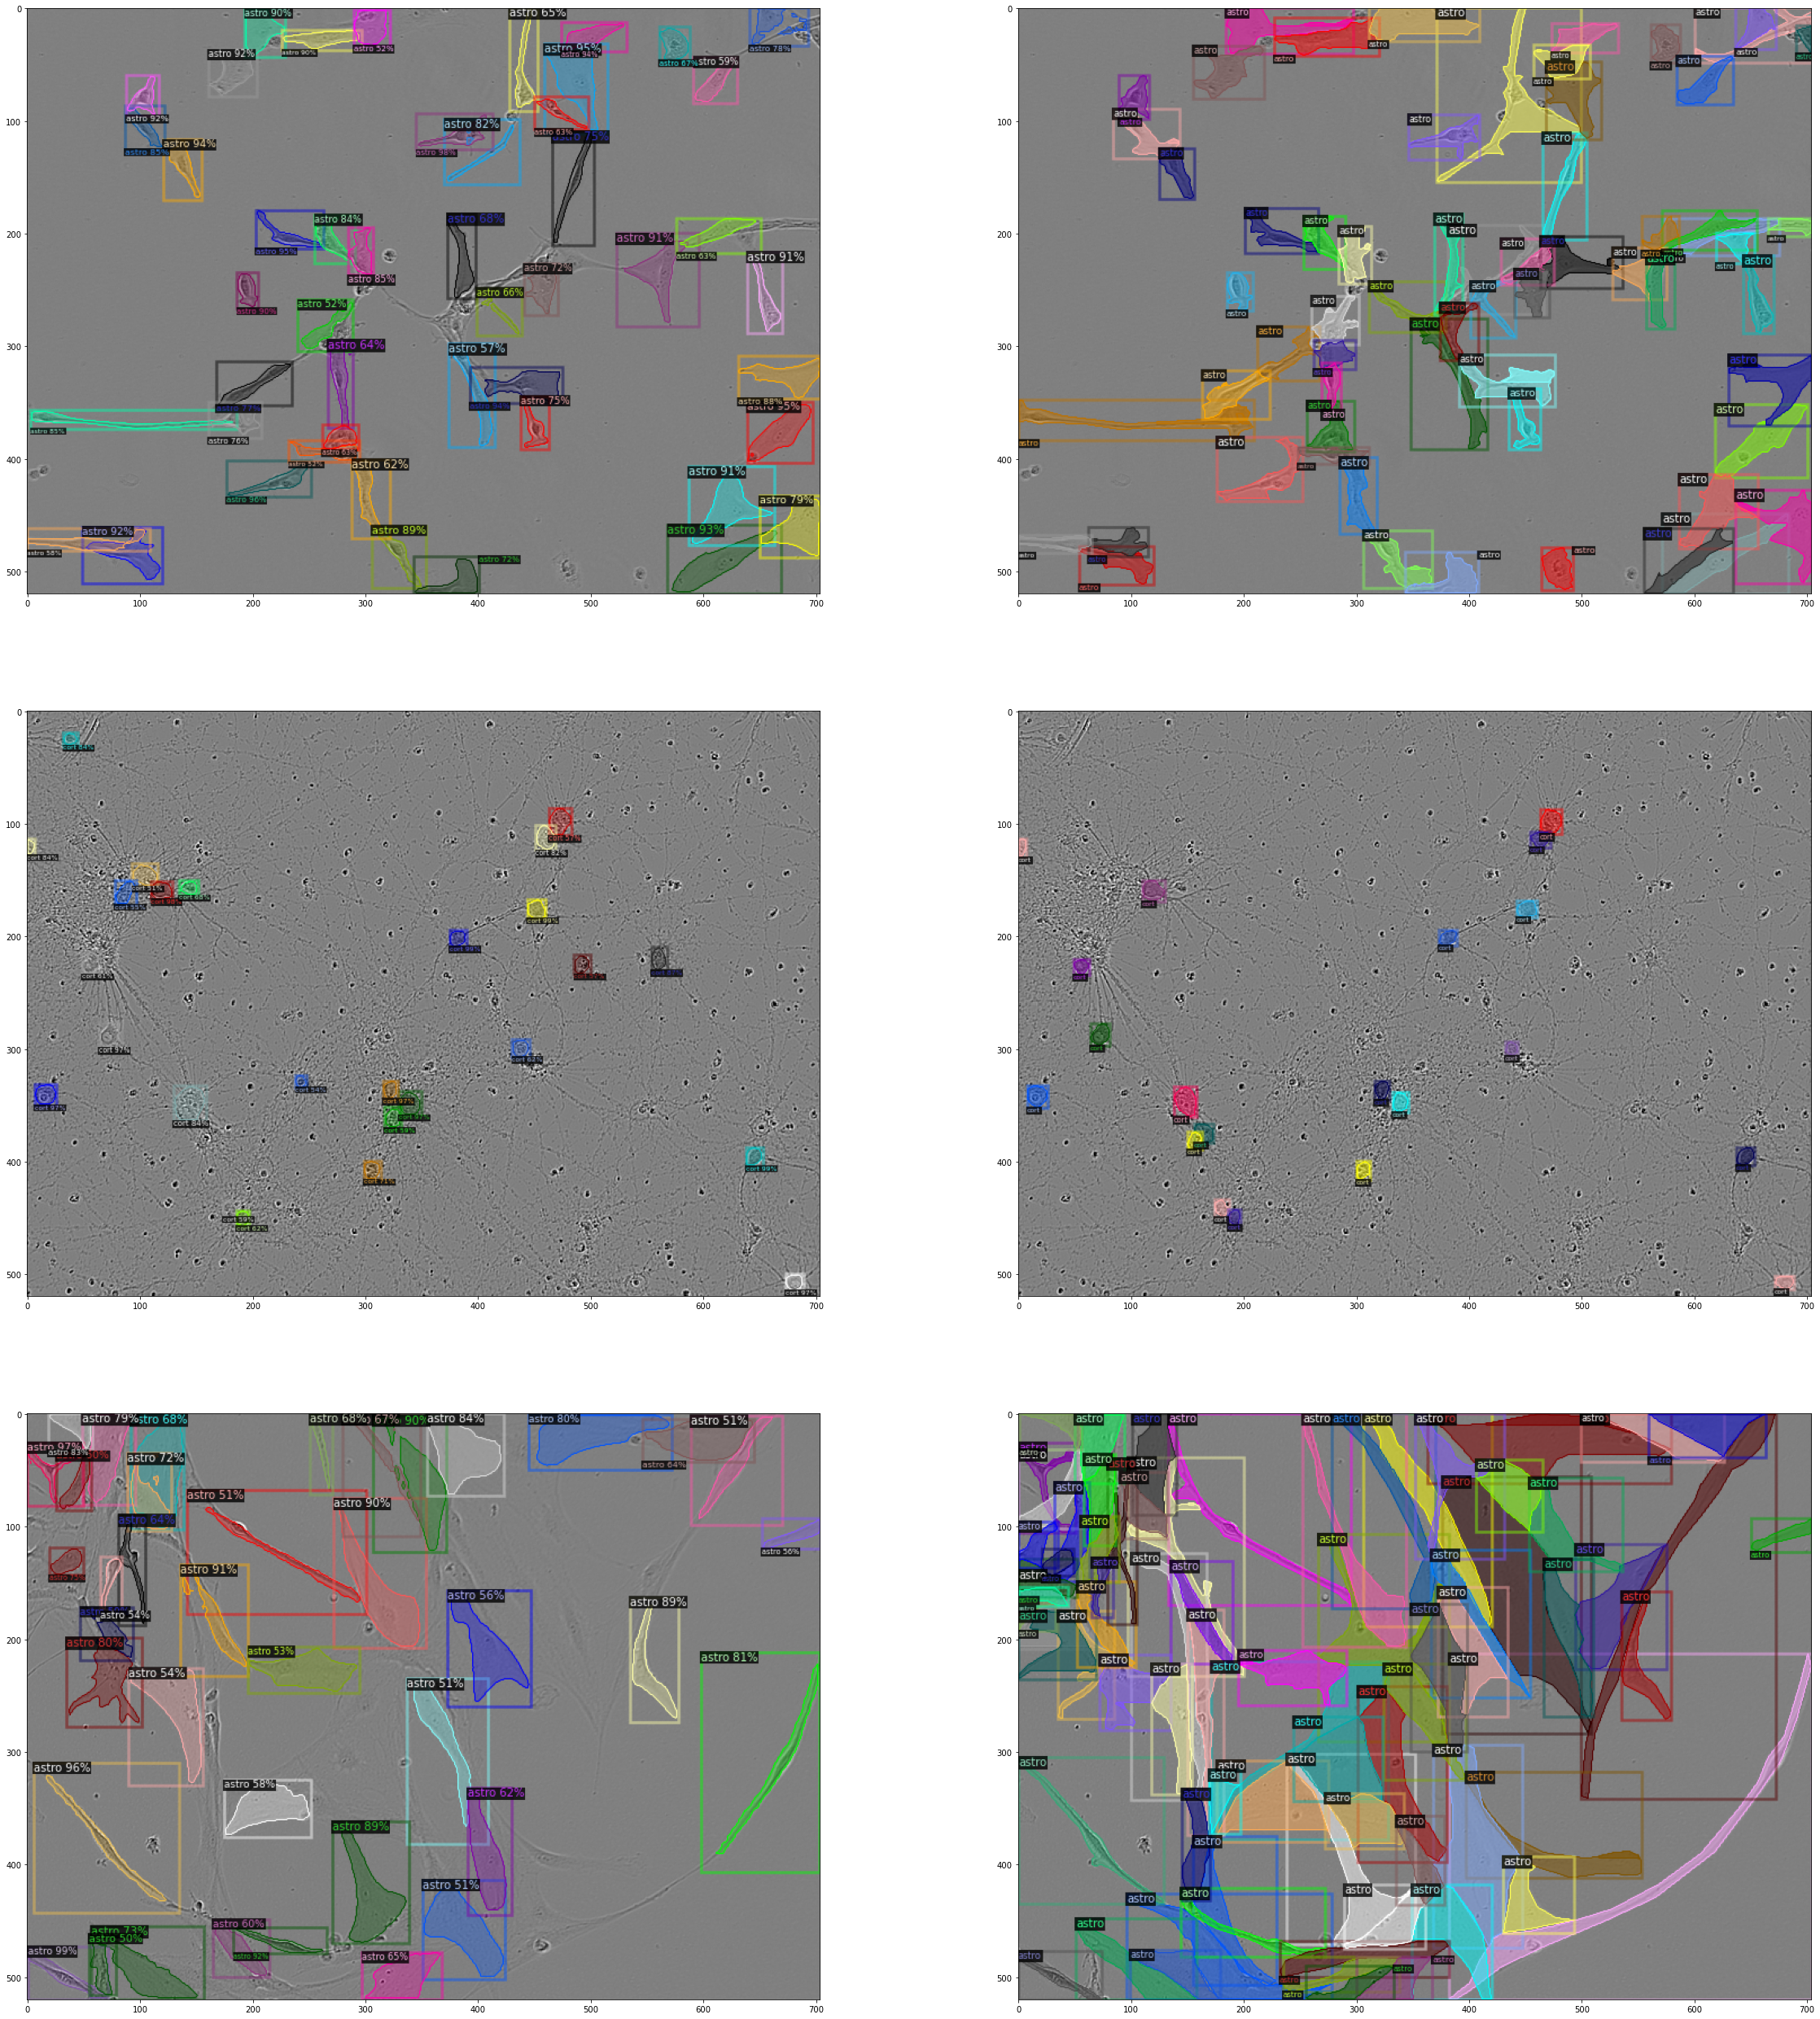

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
print(cfg.MODEL.WEIGHTS)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
dataset_dicts = DatasetCatalog.get('sart_val')
outs = []
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata = MetadataCatalog.get('sart_train'), 
                    
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get('sart_train'))
    out_target = visualizer.draw_dataset_dict(d)
    outs.append(out_pred)
    outs.append(out_target)
_,axs = plt.subplots(len(outs)//2,2,figsize=(40,45))
for ax, out in zip(axs.reshape(-1), outs):
    ax.imshow(out.get_image()[:, :, ::-1])